## scikit-learn (sklearn) - open source ML library with a lot of tools for data mining, data analysis and machine learning
## SKlearn allows to

### Features engineering and processing
* Features scaling
* One-hot/Label encoders
* Columns transformers
* Features selection algorithms
* Dimensionality reduction
* Missing data imputation

### Model selection
* Grid search, Random search algorithms
* Different cross-validation techniques
* Stacking, blending, boosting techniques

### Clusterning, manifold learning
* PCA for dimensionality reduction
* T-SNE, LLE, etc for manifold learning
* K-MEANS, DBSCAN, etc for clustering

### Metrics
* F1, roc-auc, Matthew corr coef, etc for classification
* mae, mse, etc for regression
* confusion matrix
* pearson, spearman correlations

### A lot of interesting things
* Calibration classifiers
* Pipelines
* Keras supports sklearn interface with KerasClassifier

### Lets take some data and play with it using different sklearn tools
We have 1095 samples, feature columns **f0..f1611** and some target **y**


In [102]:
import warnings
warnings.filterwarnings('ignore')

def plot_scores(param, score, std_score=None, train_scores=None, log=False):
    if std_score is None:
        mean_score = score.mean(axis=0)
        std_score = score.std(axis=0)
    else:
        mean_score = score
    
    # "Confidence intervals" (in fact, they are not, but let's stick to this term)
    score_ci_low = mean_score - std_score
    score_ci_high = mean_score + std_score
    
    if log:
        plt.semilogx(param, mean_score)
    else:
        plt.plot(param, mean_score)
    plt.fill_between(param, score_ci_low, score_ci_high, alpha=0.3)
    
    if train_scores is not None:
        if log:
            plt.semilogx(param, train_scores)
        else:
            plt.plot(param, train_scores)
    
    plt.xlabel('Parameter value')
    plt.ylabel('ROC-AUC Score')
    plt.show()

In [38]:
import pandas as pd
data = pd.read_csv("./train.csv")
target = data.y
data = data.drop(['sample_id', 'y'], axis=1)
print(data.shape)
data.head()

(1095, 1612)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f1602,f1603,f1604,f1605,f1606,f1607,f1608,f1609,f1610,f1611
0,25.609375,6.703125,3.652344,10.039062,169.375,102.8125,1.422852,6.722656,8.015625,8.109375,...,3.675781,8.070312,4.363281,5.019531,5.710938,6.343750,6.843750,7.289062,7.617188,7.980469
1,18.343750,5.824219,2.966797,4.902344,164.625,71.8125,1.357422,5.894531,2.753906,7.406250,...,3.636719,7.359375,4.195312,4.808594,5.425781,5.949219,6.339844,6.730469,7.074219,7.175781
2,28.562500,6.230469,3.583984,7.882812,159.500,113.1875,1.696289,6.316406,4.605469,7.753906,...,3.806641,8.562500,4.523438,5.097656,5.789062,6.457031,6.871094,7.386719,7.878906,8.328125
3,28.062500,6.132812,2.726562,6.378906,169.750,111.0000,1.535156,6.199219,3.712891,7.664062,...,3.156250,4.558594,3.533203,3.900391,4.261719,4.042969,3.869141,3.890625,4.042969,4.273438
4,20.109375,6.144531,3.203125,6.035156,164.750,78.8750,1.281250,6.187500,4.003906,7.734375,...,4.160156,6.613281,4.625000,4.996094,5.328125,5.593750,5.800781,6.027344,6.242188,6.449219


### It is binary classification task. Out target column is acceptable balanced

1.0    671
0.0    424
Name: y, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


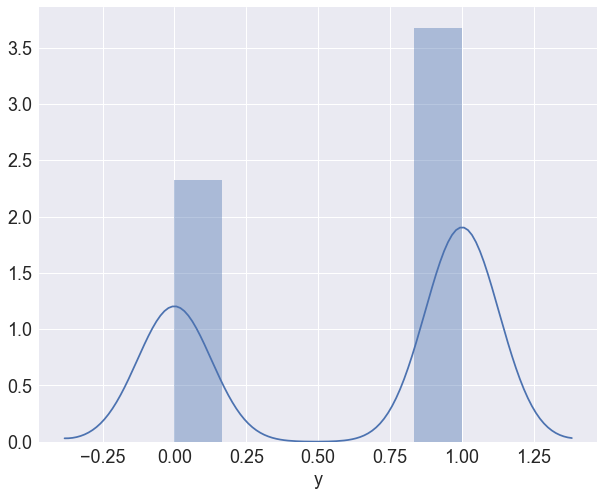

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['font.size'] = 18


import seaborn as sns

print(target.value_counts())

sns.distplot(target);

### Lets analyze missing data

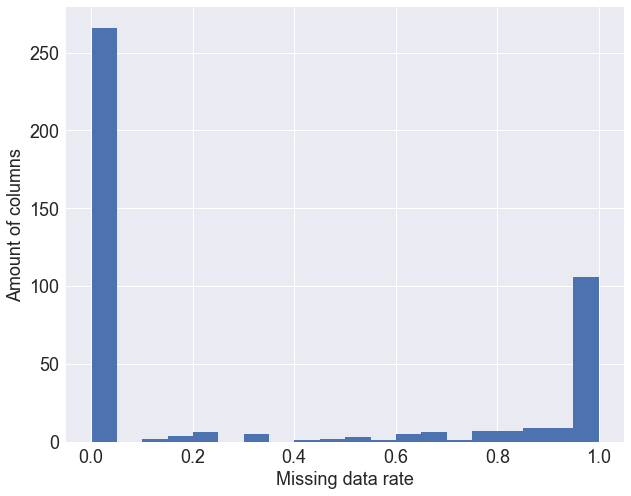

In [45]:
import numpy as np

# Replace all +- inf on NaNs for simplicity
data.replace([np.inf, -np.inf], np.nan, inplace=True)

invalid = data.shape[0] - data.count()
missing = invalid[invalid > 0]
missing_fraction = missing / data.shape[0]

plt.hist(missing_fraction, bins=20)
plt.xlabel("Missing data rate")
plt.ylabel("Amount of columns");

In [46]:
#Drop columns with >90% missing data
data = data.drop(missing_fraction[missing_fraction > 0.9].index, axis=1)

### Lets preprocess features
* Divide all features on categorical and numeric
* Apply median imputation and [0;1] scaling for numeric
* Apply mode imputation and one-hot for categorical

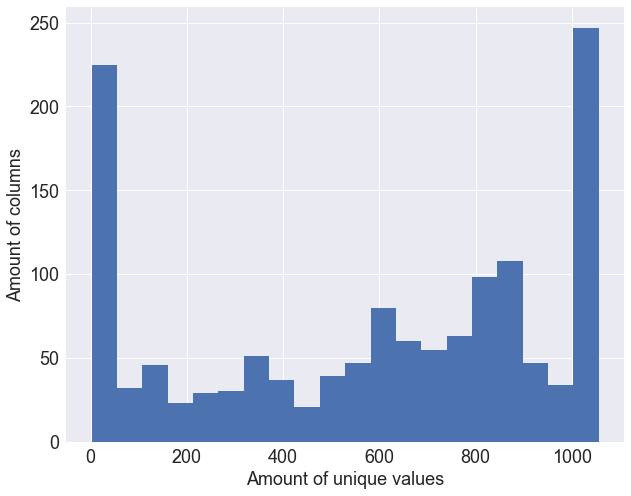

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# How many categorical features do we have?
nunique = data.nunique()
plt.hist(nunique, bins=20);
plt.xlabel("Amount of unique values")
plt.ylabel("Amount of columns");

In [51]:
# Drop columns with only one value occured
data = data.drop(columns=nunique[nunique == 1].index)
nunique = nunique[nunique > 1]

#Separate categorical and numeruc features
cat_features = nunique[nunique <= 5].index
num_features = nunique[~nunique.index.isin(cat_features)]


#Create different pipelines for each
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

data_processed = preprocessor.fit_transform(data)

print(data.shape, ndata.shape)

(1095, 1372) (1095, 1615)


In [78]:
# For simplicity lets impute ALL features by median for next examples
data_imputed = SimpleImputer(strategy='median').fit_transform(data)

# Lets analyze latent using manifold and PCA

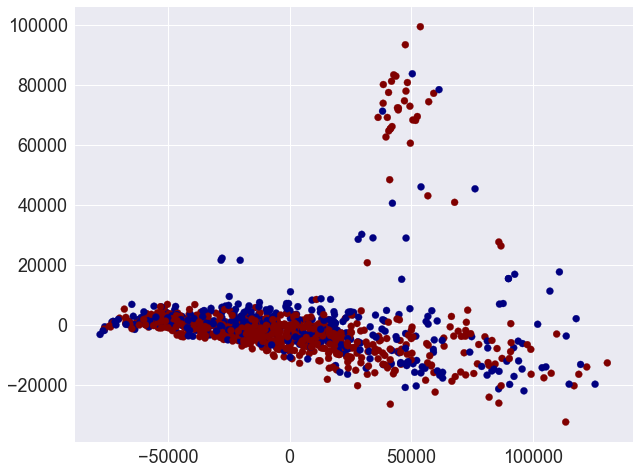

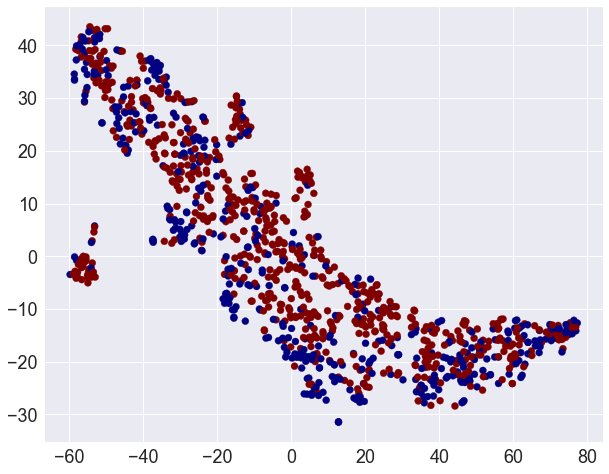

In [79]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
plt.set_cmap('jet')

#PCA, T-SNE
for algo in [PCA, TSNE]:
    embedding = algo(n_components=2).fit_transform(data_imputed)
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=target)

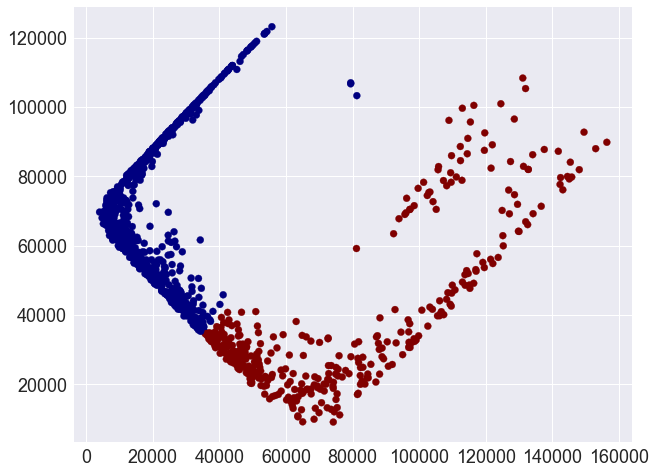

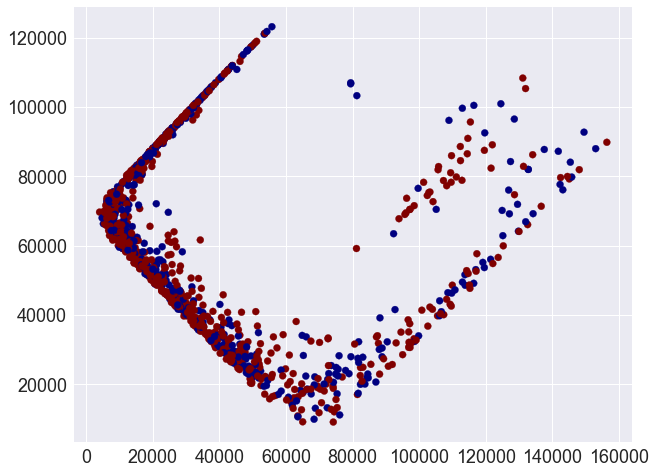

In [81]:
from sklearn.cluster import KMeans
#Also we can use DBSCAN, MeanShift, Birch, etc

kmeans = KMeans(n_clusters=2)
embedding = kmeans.fit_transform(data_imputed)
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_)

plt.figure()
plt.scatter(embedding[:, 0], embedding[:, 1], c=target)

### Outliers detection

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


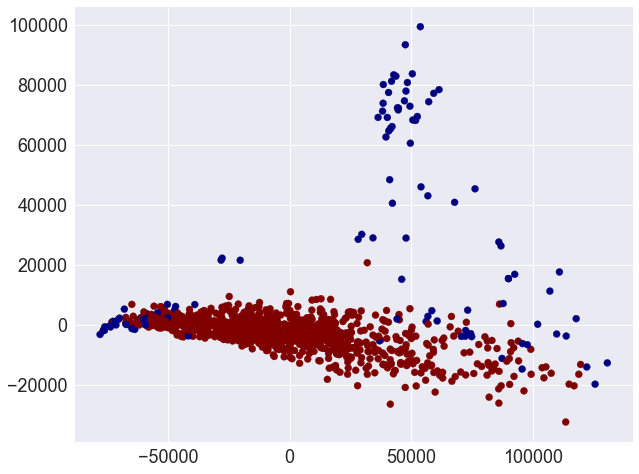

In [90]:
from sklearn.ensemble import IsolationForest
# Also we can use OneClassSVM, Robust covariance, Local Outlier Factor, etc

iforest = IsolationForest()
labels = iforest.fit_predict(data_imputed)

embedding = PCA(n_components=2).fit_transform(data_imputed)

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels)

### Models

### Simple pipeline with logistic regression

In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
lr = LogisticRegressionCV(cv=3, refit=True, scoring='roc_auc')

pipeline = make_pipeline(imputer, scaler, lr)
pipeline.fit(data, target)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
      ...andom_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=0))])

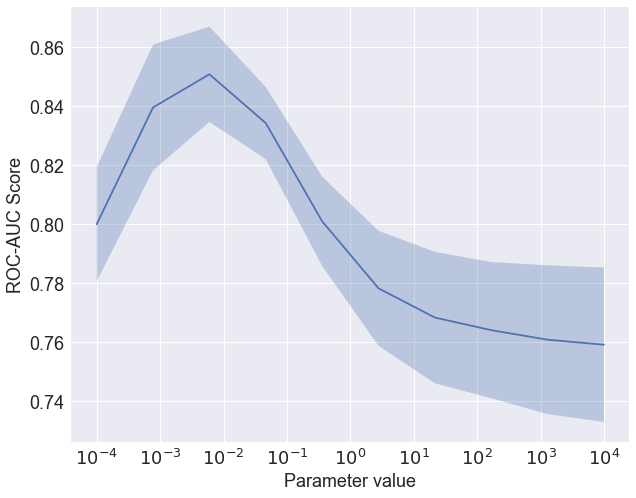

In [103]:
Cs = pipeline.steps[-1][1].Cs_
scores = pipeline.steps[-1][1].scores_[1.0]

#Plot dependency between hyperparameter C (regularuzation) and CV roc-auc score
plot_scores(Cs, scores, log=True)

### Random forest with random search and grid search

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rfc = RandomForestClassifier(n_jobs = 10)

rf_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10,50,100],
    'n_jobs': [4]
}

rsearch_rf = RandomizedSearchCV(rfc,
                                rf_grid,
                                n_iter=10,
                                scoring='roc_auc')

rsearch_rf.fit(data_imputed, target);

In [138]:
rsearch_rf.best_params_, rsearch_rf.best_score_

({'bootstrap': True,
  'max_depth': 10,
  'max_features': 'auto',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 50,
  'n_jobs': 4},
 0.853642753674932)

In [116]:
gsearch_rf = GridSearchCV(rfc,
                          rf_grid,
                          scoring='roc_auc')

gsearch_rf.fit(data_imputed, target);

### KFold, StratifiedKFold CV

In [123]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits = 3, shuffle=True)
for tr, te in kfold.split(data_imputed, target):
    print('KFOLD')
    print(pd.Series(target[te]).value_counts().values)
    
print('-'*20)

skfold = StratifiedKFold(n_splits = 3, shuffle=True)
for tr, te in skfold.split(data_imputed, target):
    print('Stratified KFOLD')
    print(pd.Series(target[te]).value_counts().values)
    

KFOLD
[226 139]
KFOLD
[218 147]
KFOLD
[227 138]
--------------------
Stratified KFOLD
[224 142]
Stratified KFOLD
[224 141]
Stratified KFOLD
[223 141]


### Train/test split

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_imputed, target, stratify=target, test_size=0.25, random_state=23)

### Select best features according to some score

In [129]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
#f_classif -- ANOVA F-value score between label/feature for classification tasks

ndata = SelectKBest(f_classif, k = 100).fit_transform(data_imputed, target)
print(ndata.shape)

rsearch_rf.fit(ndata, target);
rsearch_rf.best_score_

(1095, 100)


0.8596328133920748

### Select most uncorrelated features using PCA

In [174]:
from sklearn.linear_model import LogisticRegression
#95% of variability

pca = PCA(n_components=0.999)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)


lr = LogisticRegression()
lr.fit(X_train, y_train)
print("LR", lr.score(X_test, y_test))

lr = LogisticRegression()
lr.fit(X_train_pca, y_train)
print("LR with PCA", lr.score(X_test_pca, y_test))

(821, 1372) (821, 29)
LR 0.7554744525547445
LR with PCA 0.6678832116788321


### Calibrated classifier
Probability calibration with isotonic regression or sigmoid

In [143]:
from sklearn.calibration import CalibratedClassifierCV

rf = RandomForestClassifier(**rsearch_rf.best_params_)
rf.fit(X_train, y_train)
print("RF", rf.score(X_test, y_test))

cc = CalibratedClassifierCV(RandomForestClassifier(**rsearch_rf.best_params_), method='isotonic')
cc.fit(X_train, y_train)
print("CC", cc.score(X_test, y_test))

RF 0.7773722627737226
CC 0.7956204379562044


### Oversampling. imbalanced-learn library

In [149]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(X_train.shape, X_train_over.shape)

rf = RandomForestClassifier(**rsearch_rf.best_params_)
rf.fit(X_train_over, y_train_over)
print("RF", rf.score(X_test, y_test))

(821, 1372) (1006, 1372)
RF 0.7846715328467153


### Practice task. Simple yet complex
* Take the data and reach highest performance on test set (test.csv)
* Top 3 highest test performances will be awarded with course points